## Forecasting Models

### Pt. 1 - Patterns


In [1]:
# Imports

from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import figure
from pandas.plotting import lag_plot, autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import boxcox

### About the Data

This dataset shows sales volumes for a variety of categories, by month, from 1992 to 2020

The inital plot shows that there is some seasonality to the data

<AxesSubplot:xlabel='Month'>

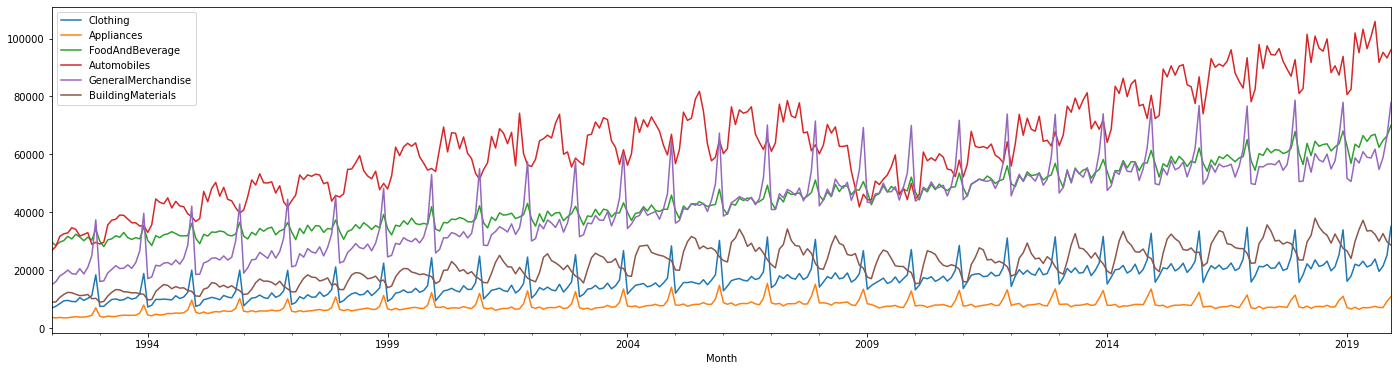

In [2]:
# Trends
# Data from Kaggle: https://www.kaggle.com/datasets/ryanholbrook/ts-course-data?select=us-retail-sales.csv
df = pd.read_csv('us-retail-sales.csv', parse_dates=['Month'])
df.plot.line('Month', ['Clothing', 'Appliances','FoodAndBeverage','Automobiles','GeneralMerchandise','BuildingMaterials'], figsize=[24,6])

### Pt. 2 - Seasonal patterns

By adding up succesive sales by the Month, it appears that for clothing, there is a spike in December (Month 12) overall. Note that by summing the results we are getting an average of what the seasonality is over the period. More detailed analysis such as comparing successive Decembers or Nov/Dec increases would provide better insight into the seasonality and how it has changed over time.

<AxesSubplot:xlabel='MonthName'>

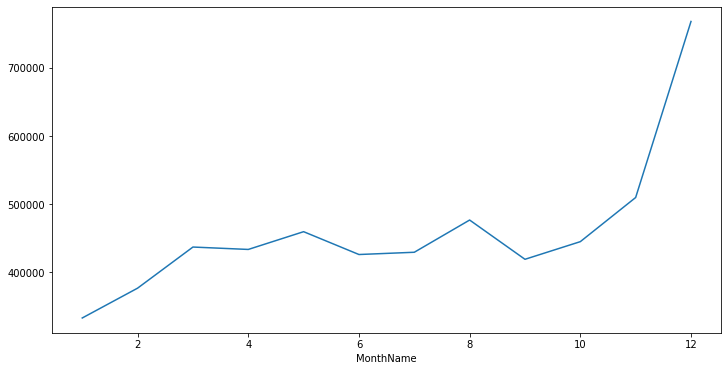

In [3]:
# Seasonal & Cyclic patterns
df['MonthName'] = pd.DatetimeIndex(df['Month']).month
subdf = df.groupby(by='MonthName')['Clothing'].sum()
subdf.plot.line('MonthName', ['Clothing'], figsize=[12,6])
# df.head(13)

We can take this a step further with seasonal subseries plots

<function matplotlib.pyplot.show(close=None, block=None)>

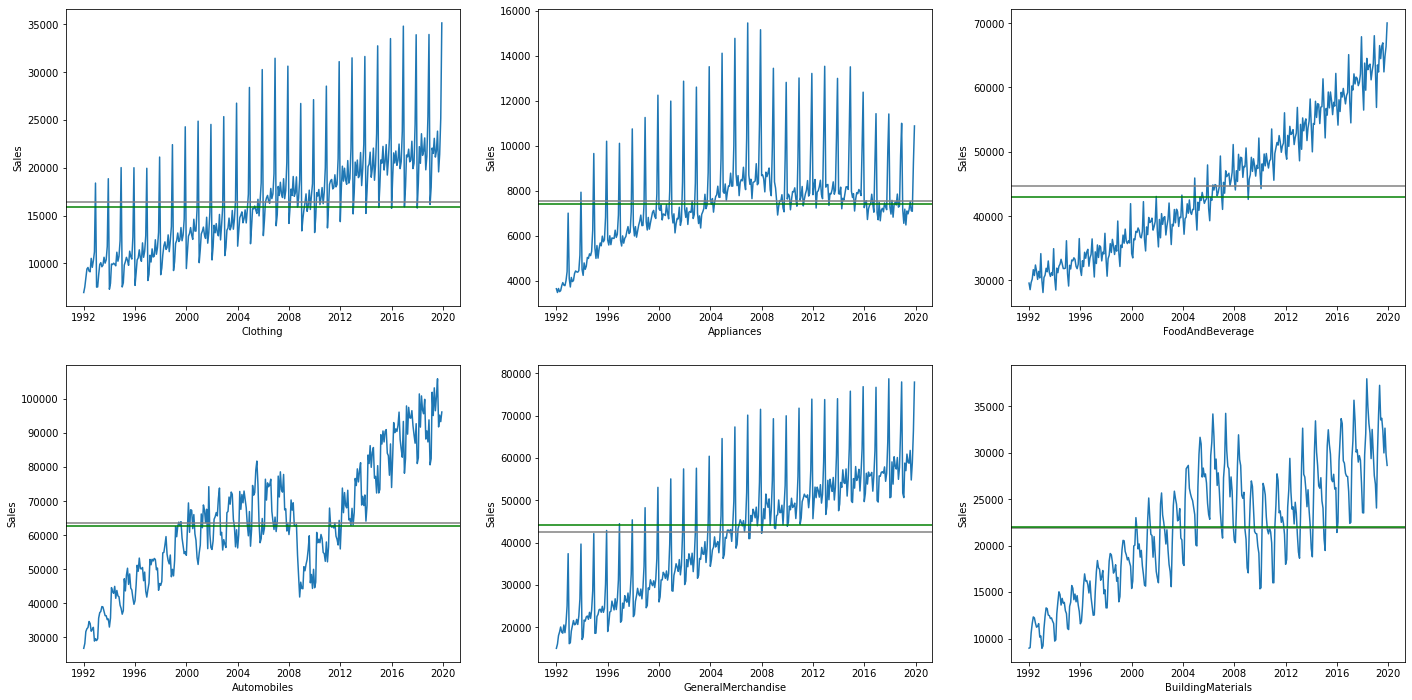

In [4]:
# df['MonthYear'] = pd.to_datetime(df['Month']).dt.to_period('M')
subseriesdf = df[['Month', 'Clothing', 'Appliances', 'FoodAndBeverage', 'Automobiles','GeneralMerchandise','BuildingMaterials']]
subseriesdf['Bin'] = pd.cut(subseriesdf['Month'],7)
# subseriesdf['MonthYear'] = pd.to_datetime(subseriesdf['MonthYear'])
# subseriesdf = 
# subseriesdf.head(10)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24,12))
# subseriesdf.plot.bar('Bin', ['Clothing'], figsize=[36,6])
for col, ax in zip(subseriesdf.columns[1:], axs.flatten()):
    ax.plot(subseriesdf['Month'], subseriesdf[col])
    ax.set(xlabel=col, ylabel='Sales')
    ax.axhline(y=np.nanmean(subseriesdf[col]), color='grey')
    ax.axhline(y=np.median(subseriesdf[col]), color='green')
plt.show
# ax1.bar(subseriesdf['Bin'], subseriesdf['Appliances'])

### Pt. 3 - Lag and Autocorrelation

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

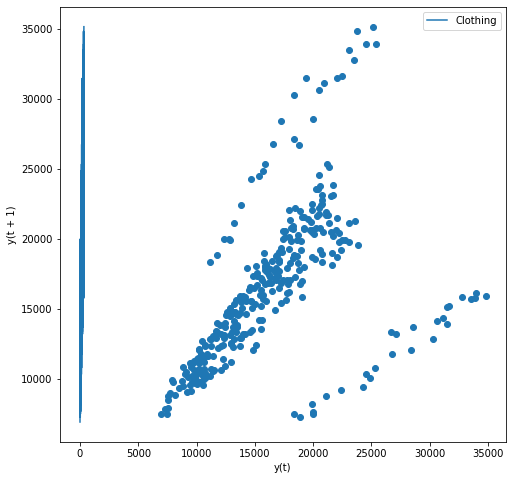

In [5]:
# Lag Plots

dfClothing = df[['Clothing']]
dfClothing.plot(figsize=[8,8])
lag_plot(dfClothing, lag=1)

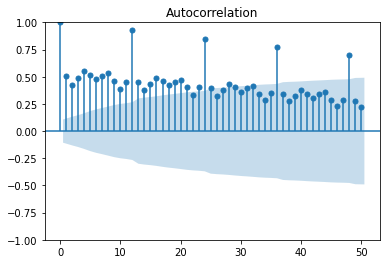

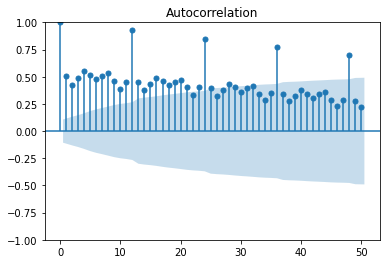

In [8]:
# Autocorrelation 

# dfClothing.plot(figsize=[18,8])
# autocorrelation_plot(dfClothing)
autoClothingdf = df[['Clothing']]
# diffClothingdf = np.diff(autoClothingdf, n=1)
plot_acf(autoClothingdf, lags=50)

Test MSE: 40300116.917


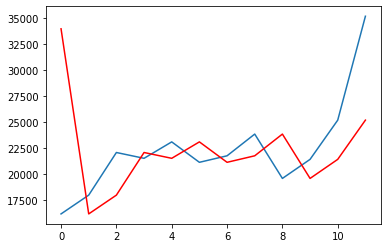

In [9]:
# Persistence Model

values = pd.DataFrame(dfClothing.values)
lagdfClothing = pd.concat([values.shift(1), values], axis=1)
lagdfClothing.columns = ['t-1', 't+1']
X = lagdfClothing.values
train, test = X[1:len(X)-12], X[len(X)-12:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
	return x

# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

### Pt. 4 - Autoregression (AR) and Moving Average (MA)

Coefficients: [ 5.08340801e+02  5.07877850e-05  4.86639134e-03  1.34504894e-02
  1.59152600e-03  1.14597779e-02  3.31643158e-03  8.65381123e-05
  3.05877100e-04 -1.16216248e-02 -1.74346810e-02 -4.62326981e-03
  9.95654373e-01]
predicted=16297.518840, expected=16155.000000
predicted=18971.752315, expected=17961.000000
predicted=22760.520538, expected=22059.000000
predicted=20886.155151, expected=21500.000000
predicted=24093.901205, expected=23079.000000
predicted=21723.558572, expected=21116.000000
predicted=22166.361015, expected=21742.000000
predicted=23572.670250, expected=23829.000000
predicted=20030.648183, expected=19567.000000
predicted=21522.228883, expected=21400.000000
predicted=25889.068305, expected=25170.000000
predicted=34387.707132, expected=35157.000000
Test RMSE: 638.657


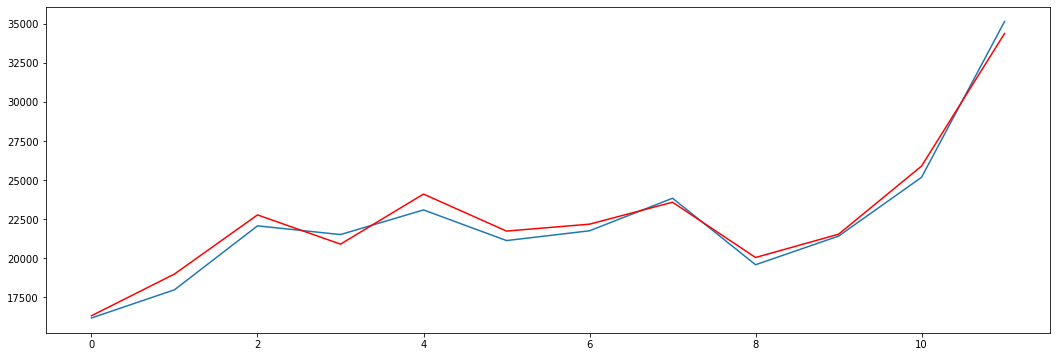

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  323
Model:                    AutoReg(12)   Log Likelihood               -2471.715
Method:               Conditional MLE   S.D. of innovations            684.506
Date:                Mon, 19 Jun 2023   AIC                           4971.429
Time:                        20:13:35   BIC                           5023.786
Sample:                            12   HQIC                          4992.357
                                  323                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        508.3408    170.630      2.979      0.003     173.911     842.770
y.L1        5.079e-05      0.010      0.005      0.996      -0.020       0.020
y.L2           0.0049      0.010      0.470      0.6

In [10]:
# AR Model (Run Persistence model first)

# model = AutoReg(train, lags=1)
series = pd.read_csv('us-retail-sales.csv', header=0, index_col=0, parse_dates=True)
X = series.values
train, test = X[1:len(X)-12,0], X[len(X)-12:,0]
model = AutoReg(train, lags=12)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.rcParams["figure.figsize"] = (18,6)
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
print(model_fit.summary())

In [14]:
# MA Model

movingaveragedf = df[['Month', 'Clothing']]

movingaveragedf['Passengers_boxcox'], lam = boxcox(movingaveragedf['Clothing'])
movingaveragedf["Passenger_stationary"] = movingaveragedf["Passengers_boxcox"].diff()
movingaveragedf.dropna(inplace=True)



# Plot the stationary airline passenger data
# plot_passenger_volumes(df=movingaveragedf, y='Passenger_stationary')

<ipython-input-14-9431ded82e13>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movingaveragedf['Passengers_boxcox'], lam = boxcox(movingaveragedf['Clothing'])
<ipython-input-14-9431ded82e13>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movingaveragedf["Passenger_stationary"] = movingaveragedf["Passengers_boxcox"].diff()
<ipython-input-14-9431ded82e13>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

C:\Users\brend\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Coefficients: [-9.71336554e-02 -8.52620417e-02 -7.99415308e-02 -8.45857950e-02
 -7.53640135e-02 -7.45524948e-02 -7.34275640e-02 -6.32269879e-02
 -7.18122104e-02 -7.23093452e-02 -6.78991136e-02  9.02172131e-01
  4.03375271e+05]
predicted=16067.369230, expected=16155.000000
predicted=18910.866592, expected=17961.000000
predicted=22603.319496, expected=22059.000000
predicted=20792.069386, expected=21500.000000
predicted=23904.432989, expected=23079.000000
predicted=21598.356099, expected=21116.000000
predicted=22056.018494, expected=21742.000000
predicted=23469.894891, expected=23829.000000
predicted=19971.427333, expected=19567.000000
predicted=21461.532399, expected=21400.000000
predicted=25564.474039, expected=25170.000000
predicted=33711.879091, expected=35157.000000
Test RMSE: 662.085


C:\Users\brend\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


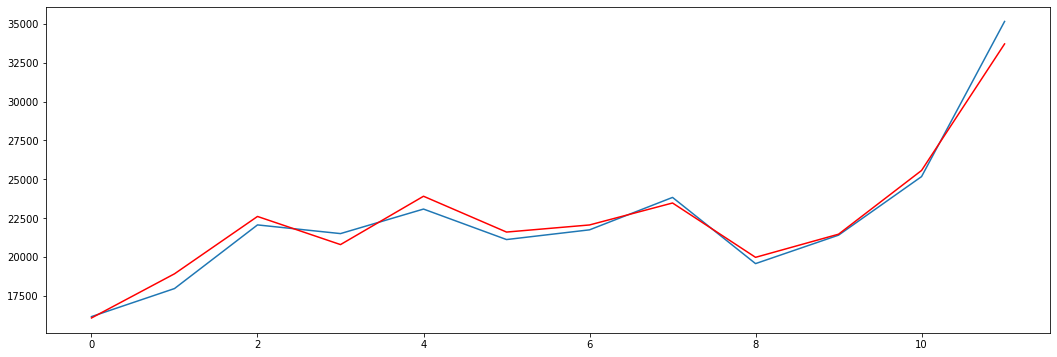

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  323
Model:                ARIMA(12, 1, 0)   Log Likelihood               -2597.622
Date:                Mon, 19 Jun 2023   AIC                           5221.244
Time:                        20:13:41   BIC                           5270.313
Sample:                             0   HQIC                          5240.834
                                - 323                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0971      0.018     -5.535      0.000      -0.132      -0.063
ar.L2         -0.0853      0.016     -5.282      0.000      -0.117      -0.054
ar.L3         -0.0799      0.016     -4.866      0.0

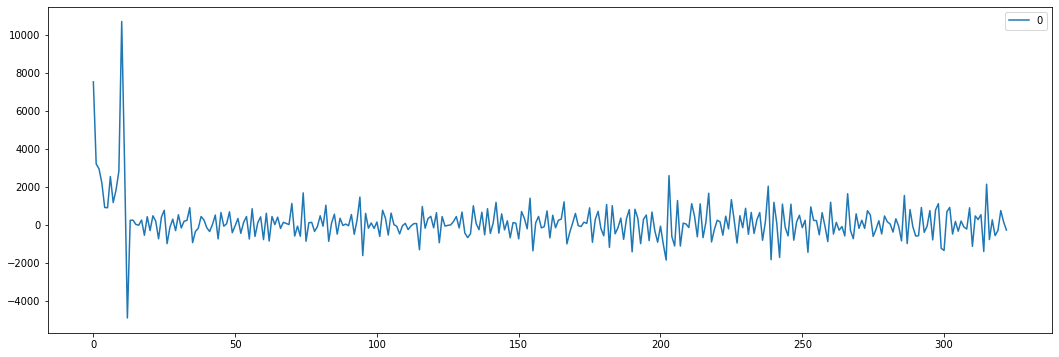

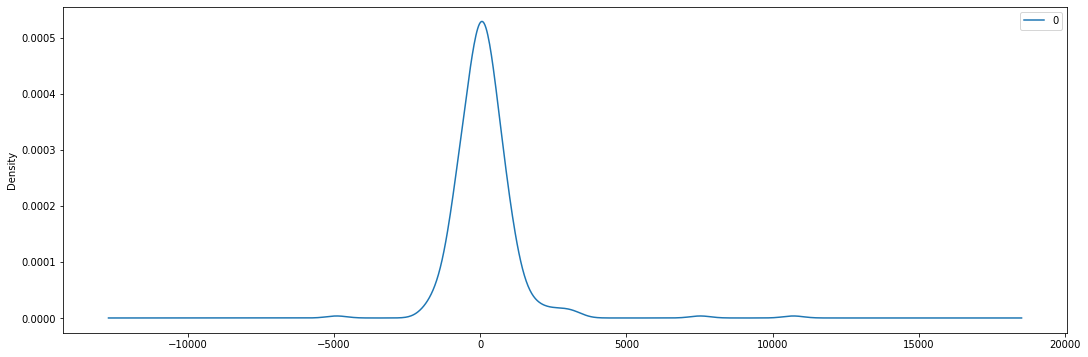

In [11]:
# ARMA Model
series = pd.read_csv('us-retail-sales.csv', header=0, index_col=0, parse_dates=True)
X = series.values
train, test = X[1:len(X)-12,0], X[len(X)-12:,0]
model = ARIMA(train, order=(12,1,0))

model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.rcParams["figure.figsize"] = (18,6)
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# Show residuals
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [ ]:
# ARIMA Model